In [222]:
import torch
from spikingjelly.activation_based import neuron
import matplotlib.pyplot as plt

In [223]:
input = torch.zeros([100])
input[10:20] = 0.5
input[40:50] = 1.0
input[42:44] = 5.0
input[70:90] = 1.0

input1 = torch.zeros([100])
input1[5:15] = 0.3
input1[30:35] = 0.7
input1[32:33] = 3.0
input1[60:80] = 1.0

input2 = torch.zeros([100])
input2[0:10] = 0.2
input2[20:25] = 0.8
input2[22:24] = 4.0
input2[50:60] = 1.0
input2[85:95] = 0.6

In [224]:
input = torch.stack([input, input1, input2], dim=1) # L, C

In [225]:
if input.dim() == 2:
    diff = torch.zeros([100, 3])
    diff[1:, :] = input[1:, :] - input[:-1, :]
else:
    diff = torch.zeros([100])
    diff[1:] = input[1:] - input[:-1]

In [226]:
# normalize input
input = input / input.abs().max()
# normalize diff
diff = diff / diff.abs().max()

In [227]:
lif1 = neuron.LIFNode(step_mode='m')
lif2 = neuron.LIFNode(step_mode='s')

In [228]:
fc = torch.nn.Linear(3, 1, bias=False)

In [229]:
integrated = fc(input)
print(integrated.shape)
integrated_diff = fc(diff)

torch.Size([100, 1])


In [230]:
# SA-I
#sa_i = neuron.IzhikevichNode(a=0.001, b=0.1, tau_w=10.0, a0=1.5, step_mode='m', store_v_seq=True)
sa_i = neuron.IzhikevichNode(step_mode='m')
# FA-I
#fa_i = neuron.IzhikevichNode(a=0.75, b=0.25, tau_w=2.0, a0=0.8, step_mode='m', store_v_seq=True)
fa_i = neuron.IzhikevichNode(step_mode='m')

In [231]:
seq_sa_i = sa_i(integrated) # L, C
seq_fa_i = fa_i(integrated_diff) # L, C

#seq_lif1 = lif1(input)
#seq_lif2 = lif2(diff)

In [232]:
print(seq_sa_i.shape, seq_fa_i.shape)

torch.Size([100, 1]) torch.Size([100, 1])


In [233]:
#output = torch.stack([seq_sa_i, seq_fa_i], dim=0) # C, L
output = torch.concat([seq_sa_i, seq_fa_i], dim=1) # L, C*2
print("Output Shape:", output.shape)
# Maxpooling on each step
output_max = torch.max(output, dim=1).values
output_avg = torch.mean(output, dim=1)
#print("Maxpooling Output Shape:", output_max.shape)
output_attention = output_avg + output_max

Output Shape: torch.Size([100, 2])


In [234]:
print(output_max.shape)
print(output_avg.shape)

torch.Size([100])
torch.Size([100])


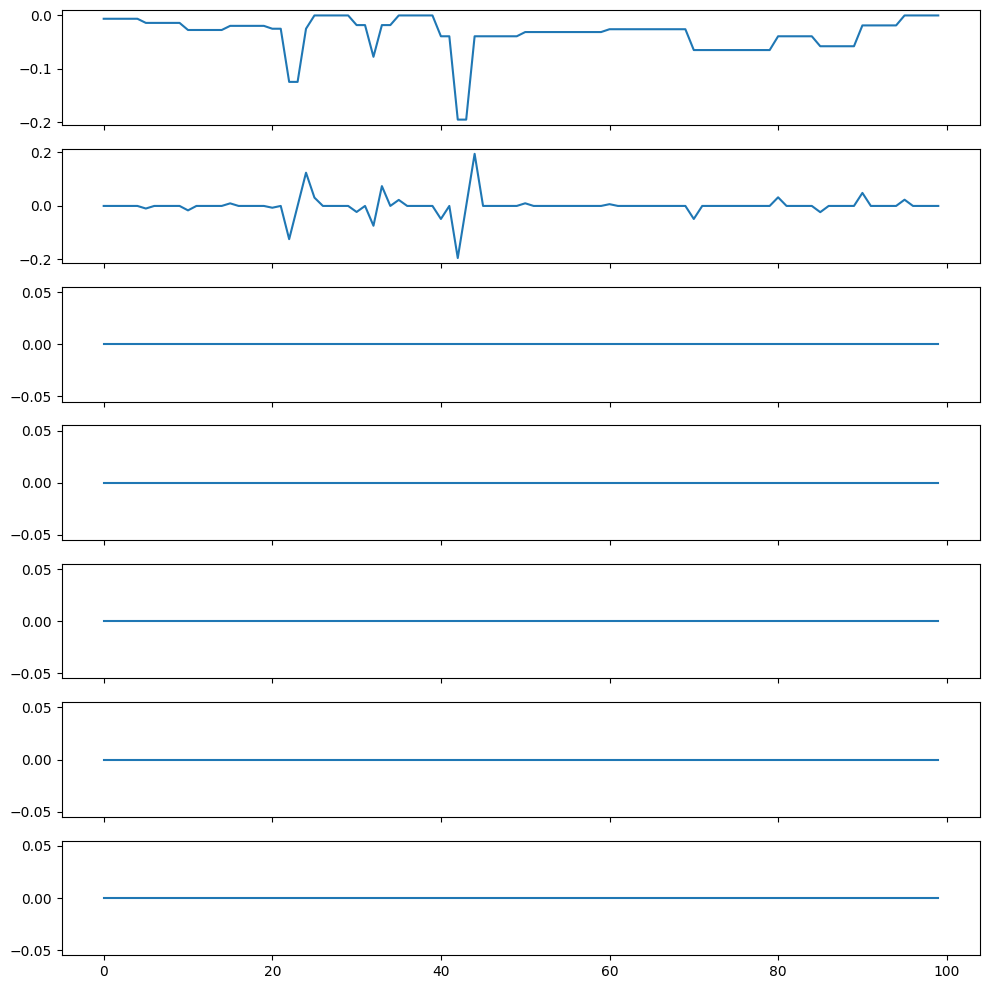

In [235]:
fig, axs = plt.subplots(2+1+1+3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(integrated[:, 0].detach(), label='Integrated Input 1')
axs[1].plot(integrated_diff[:, 0].detach(), label='Integrated Diff Input 1')
axs[2].plot(seq_sa_i[:, 0].detach(), label='SA-I Output 1')
axs[3].plot(seq_fa_i[:, 0].detach(), label='FA-I Output 1')
axs[4].plot(output_max.detach().numpy(), label='Maxpooling Output')
axs[5].plot(output_avg.detach().numpy(), label='Average Output')
axs[6].plot(output_attention.detach().numpy(), label='Attention Output')
plt.tight_layout()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

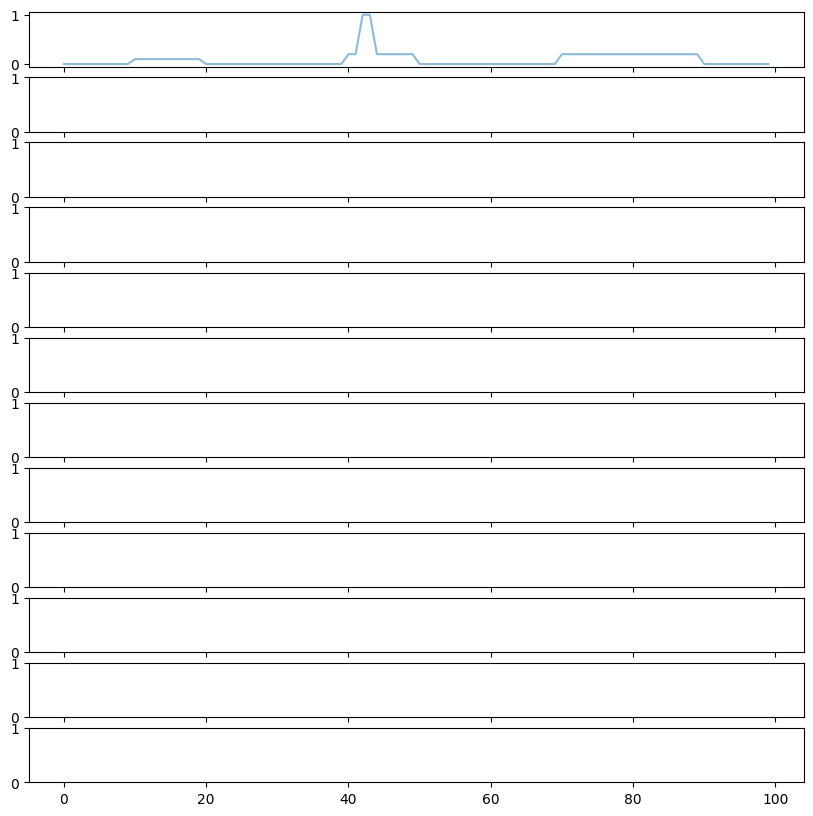

In [236]:
fig, axs = plt.subplots(12, 1, figsize=(10, 10), sharex=True)

num_channels = input.shape[1]
for i in range(num_channels):
    axs[i].plot(input[:, i], label=f'Input Channel {i+1}', alpha=0.5)
    axs[3+i].plot(seq_sa_i[:, i], label=f'SA-I Channel {i+1}', alpha=0.5)
    axs[6+i].plot(seq_fa_i[:, i], label=f'FA-I Channel {i+1}', alpha=0.5)
#axs[0].plot(input, label='Input Signal', color='gray')

    
#axs[1].plot(seq_sa_i, label='SA-I Neuron', color='blue')
#axs[1].set_title('SA-I Neuron Response')

#axs[2].plot(seq_fa_i, label='FA-I Neuron', color='orange')
#axs[2].set_title('FA-I Neuron Response')

axs[9].plot(output_max, label='Maxpooling Output', color='green')
axs[9].set_title('Maxpooling Output')

axs[10].plot(output_avg, label='Average Output', color='red')
axs[10].set_title('Average Output')

axs[11].plot(output_attention, label='Attention Output', color='purple')

#axs[6].plot(seq_lif1, label='LIF Neuron 1', color='cyan')
#axs[7].plot(seq_lif2, label='LIF Neuron 2', color='magenta')

axs[-1].set_xlabel('Time Steps')

plt.tight_layout()
plt.show()